<a href="https://colab.research.google.com/github/DreamTeamInc/Core-DS/blob/issues%2F1/Core_EDA_Andrew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Path to 'sample_core_analysis_data_example' folder with folder name
path_to_data = 'drive/My Drive/ sample_core_analysis_data_example'

Mounted at /content/drive


# Initializing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2 as cv
import seaborn as sns

from PIL import Image
from skimage import exposure
from skimage import io

import sklearn
import warnings
warnings.filterwarnings('ignore')

## **Functions for getting data** 

In [3]:
def get_photo(data,i):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(data['photo_id'][i]))

def get_photo_by_id(data,id):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(id))

def get_mask(data, i):
    return np.load(path_to_data + '/matrixes/matrix_{}__{}.npz'.format(data['photo_id'][i], data['task_id'][i]))['data']

def get_json(data,i):
  with open(path_to_data + '/extra/extra_{}__{}.json'.format(data['photo_id'][i],data['task_id'][i])) as json_data:
    d = json.load(json_data)
    json_data.close()
  return d

## **Functions for displaying data**


In [4]:
def show_image(image,nrows=1,ncols=1,cmap='gray'):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
  ax.imshow(image)
  ax.axis('off')
  return fig, ax

def show_all_photo_data(data,i):
  print(data.iloc[i])
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
  ax1.imshow(get_photo(data, i))
  
  mask = get_mask(data,i)
  cmap = plt.get_cmap('tab20b', np.max(mask) + 1)
  mask = ax2.imshow(mask, cmap=cmap,vmin=-0.5, vmax=np.max(get_mask(data, i))+0.5)
  ax2.axis('off')
  fig.colorbar(mask, ticks=np.arange(0, np.max(get_mask(data, i))+1))
  return fig, (ax1, ax2)

def show_photo_series(data, column, value):
    fig, ax_ar = plt.subplots(1, 10, figsize=(14, 14))
    filt_data = data[data[column] == value]
    i = np.random.randint(0, filt_data.shape[0])
    for ax in ax_ar:
        filt_by_photo = filt_data[filt_data['photo_id'] == filt_data['photo_id'].iloc[i]]
        segments = filt_by_photo['segment_num'].values
        photo = get_photo(data, filt_by_photo.index.values[0])
        mask = get_mask(data, filt_by_photo.index.values[0])
        for value in segments:
            mask = np.ma.masked_where(mask == value, mask)
        
        ax.imshow(photo)
        ax.imshow(mask)
        ax.axis('off')
        filt_data.drop(filt_by_photo.index.values, axis=0, inplace=True)
        i = np.random.randint(0, filt_data.shape[0])
    
    return fig, ax_ar

# **Preprocessing**

In [5]:
all_data = pd.read_csv(path_to_data + '/data.csv')

In [6]:
uv_data = all_data[all_data['photo_type'] == 'УФ']
uv_data.reset_index(inplace = True, drop = True)

# **Machine Learning**

In [55]:
features_arr = pd.read_csv('drive/My Drive/data/best_features.csv')

In [56]:
features = pd.DataFrame(features_arr)

In [57]:
y = uv_data['segment_value']
#y = uv_data['segment_value'][:500]

## **SVM**

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV


parametrs = {'kernel':('linear', 'rbf'), 'C':[1, 10],'degree':[3,4,5,6,7,8],
             'tol':[1e-3,1e-4,5e-4]}
svc = svm.SVC()

clf = GridSearchCV(svc,parametrs)


clf.fit(X_train,y_train)

clf.best_params_

In [51]:
from sklearn import svm, metrics
from sklearn.model_selection import cross_validate


classifier = svm.SVC(C=10,degree=3,kernel='rbf',tol=0.01)

scores = cross_validate(classifier, features, y, scoring='f1_macro')

sum(scores['test_score'])/5

0.8409187366682789

## **RandomForestClassifier**

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, shuffle=False)


parametrs = {'n_estimators' : [320,330,340],'random_state' : [0],
             'criterion':['gini', 'entropy']}

rfc = RandomForestClassifier()

clf = GridSearchCV(rfc,parametrs)


clf.fit(X_train,y_train)

clf.best_params_

{'criterion': 'gini', 'n_estimators': 320, 'random_state': 0}

In [52]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


forest = RandomForestClassifier(criterion='entropy',random_state=0)



scores = cross_validate(forest, features, y, scoring='f1_macro')

sum(scores['test_score'])/5

0.8793935042474994

In [ ]:
scores = cross_val_score(forest, X_test, y_test, cv=5)
scores

array([0.87155963, 0.91743119, 0.89814815, 0.9537037 , 0.90740741])

## **ExtraTrees**

In [ ]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, shuffle=False)


parametrs = {'n_estimators' : [50,100,150,200],'random_state' : [0],
             'criterion':['gini', 'entropy'], 'min_samples_split' : [2,3,4], 'min_samples_leaf' : [1,2,3],'ccp_alpha' : [0.0, 1,2]}

etc = ExtraTreesClassifier()

clf = GridSearchCV(etc,parametrs)


clf.fit(X_train,y_train)

clf.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200,
 'random_state': 0}

In [102]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import  metrics
from sklearn.model_selection import cross_validate

etc = ExtraTreesClassifier(criterion= 'gini',min_samples_split= 3)

scores = cross_validate(etc, features, y, scoring='f1_macro')

sum(scores['test_score'])/5

0.8901510312734846

In [133]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(features,y,test_size=0.33)

etc.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=3,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

## **3-chanel histogram with equalization**

In [7]:
def histogram_equalize(img): 
    img_cdf, bin_centers = exposure.cumulative_distribution(img) 
    return np.interp(img, bin_centers, img_cdf)

In [136]:
def get_features(photo,mask,segment_num):
  # Get segment from photo
  p1 = np.ma.masked_where(mask == segment_num, photo[:,:,0])
  p2 = np.ma.masked_where(mask == segment_num, photo[:,:,1])
  p3 = np.ma.masked_where(mask == segment_num, photo[:,:,2])
  # Get histograms 3 chanels of photo
  hist1 = np.histogram(p1.mask * p1.data, bins = 32, range = (0,1))
  hist2 = np.histogram(p2.mask * p2.data, bins = 32, range = (0,1))
  hist3 = np.histogram(p3.mask * p3.data, bins = 32, range = (0,1))
  
  features = np.concatenate((np.array(hist1[0][1:] / np.sum(p1.mask),dtype=object),
                             np.array(hist2[0][1:] / np.sum(p2.mask),dtype=object),
                             np.array(hist3[0][1:] / np.sum(p3.mask),dtype=object)))
  return features

In [ ]:
from skimage.color import rgb2hsv

def data_preprocessing(data):
  features_arr = []
  for i in range(data.shape[0]):
    segment_num = data['segment_num'].iloc[i]
    photo = get_photo(data,i)
    mask = get_mask(data,i)

    hsv_features = get_features( rgb2hsv(photo),mask,segment_num) 
    rgb_features = get_features(histogram_equalize(photo),mask,segment_num)
    
    photo_features = np.concatenate((hsv_features,rgb_features))         
    features_arr.append(list(photo_features))
    features = pd.DataFrame(features_arr)


  return features_arr


## **Selection of important features**

In [87]:
features = data_preprocessing(uv_data)

In [ ]:
forest.fit(features,y)


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

main_features = []
for f in range(features.shape[1]):
    main_features.append(indices[f]) 

for i in range(len(f)):
  features.drop(f[i],axis='columns', inplace=True)


# **Segmentation**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


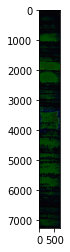

In [10]:
from skimage import filters

photo = get_photo(uv_data,1500)

photo = filters.laplace(photo)

plt.imshow(photo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


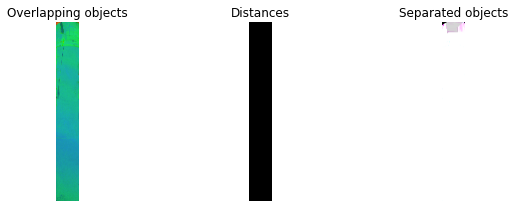

In [ ]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.color import rgb2hsv

photo = get_photo(uv_data,4)

photo = rgb2hsv(photo)

distance = ndimage.distance_transform_edt(photo)
local_maxi = peak_local_max(distance, indices=False,labels=photo)
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=photo)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(photo, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [8]:
def mask_transform(data,i,segment_value):
  photo_data = data[data['photo_id'] == data['photo_id'].iloc[i]]
  photo_data = photo_data[photo_data['segment_value'] == segment_value]
  seg_num = photo_data['segment_num']
  mask = get_mask(data,i)
  for k in seg_num:
    for i in range(mask.shape[0]):
      for j in range(mask.shape[1]):
        if mask[i][j] == k:
          mask[i][j] = 1
        else:
          mask[i][j] = 0
  return mask